In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ERA_V2/Assignment20/

/content/drive/MyDrive/ERA_V2/Assignment20


In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, image_dim, label_dim, embedding_dim, latent_dim):
        super(VariationalEncoder, self).__init__()

        # Embedding layer for labels
        self.label_embedding = nn.Embedding(label_dim, embedding_dim)

        # Encoder layers for concatenated image and label
        self.fc1 = nn.Linear(image_dim + embedding_dim, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log-variance

    def forward(self, x, labels):
        # Flatten image
        x = x.view(-1, 28*28)

        # Embed labels and concatenate with image
        labels = self.label_embedding(labels)
        x = torch.cat([x, labels], dim=1)

        # Pass through encoder layers
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)

        return mu, logvar

class VariationalDecoder(nn.Module):
    def __init__(self, latent_dim, label_dim, embedding_dim, image_dim):
        super(VariationalDecoder, self).__init__()

        # Embedding layer for labels
        self.label_embedding = nn.Embedding(label_dim, embedding_dim)

        # Decoder layers for concatenated latent vector and label
        self.fc3 = nn.Linear(latent_dim + embedding_dim, 400)
        self.fc4 = nn.Linear(400, image_dim)

    def forward(self, z, labels):
        # Embed labels and concatenate with latent vector
        labels = self.label_embedding(labels)
        z = torch.cat([z, labels], dim=1)

        # Pass through decoder layers
        h3 = F.relu(self.fc3(z))
        x_reconstructed = torch.sigmoid(self.fc4(h3))

        return x_reconstructed


In [7]:
class VAE(nn.Module):
    def __init__(self, image_dim=28*28, label_dim=10, embedding_dim=10, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder(image_dim, label_dim, embedding_dim, latent_dim)
        self.decoder = VariationalDecoder(latent_dim, label_dim, embedding_dim, image_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z, labels)
        return x_reconstructed, mu, logvar

# Loss function for VAE
def loss_function(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [8]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
vae.train()
for epoch in range(30):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = vae(data, labels)
        loss = loss_function(reconstructed_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}")

Epoch 0, Loss: 142.66532267659505
Epoch 1, Loss: 112.65558103841146
Epoch 2, Loss: 107.69056385498047
Epoch 3, Loss: 105.28914855143229
Epoch 4, Loss: 103.84970158284506
Epoch 5, Loss: 102.91030728352865
Epoch 6, Loss: 102.17960126139323
Epoch 7, Loss: 101.64417391357422
Epoch 8, Loss: 101.25920972493489
Epoch 9, Loss: 100.90222843017578
Epoch 10, Loss: 100.54422532552083
Epoch 11, Loss: 100.26513733317057
Epoch 12, Loss: 100.04810825195312
Epoch 13, Loss: 99.83936303710938
Epoch 14, Loss: 99.62593955078125
Epoch 15, Loss: 99.46400417480469
Epoch 16, Loss: 99.27708014322917
Epoch 17, Loss: 99.11218131917317
Epoch 18, Loss: 99.01068368326823
Epoch 19, Loss: 98.83747705078125
Epoch 20, Loss: 98.71861076253255
Epoch 21, Loss: 98.62588959960938
Epoch 22, Loss: 98.53819373779297
Epoch 23, Loss: 98.36796717936198
Epoch 24, Loss: 98.35091259358724
Epoch 25, Loss: 98.23351130371094
Epoch 26, Loss: 98.14331842854817
Epoch 27, Loss: 98.0948369181315
Epoch 28, Loss: 97.9501984741211
Epoch 29, Los

In [9]:
# Save the trained model
torch.save(vae.state_dict(), 'vae_mnist.pth')

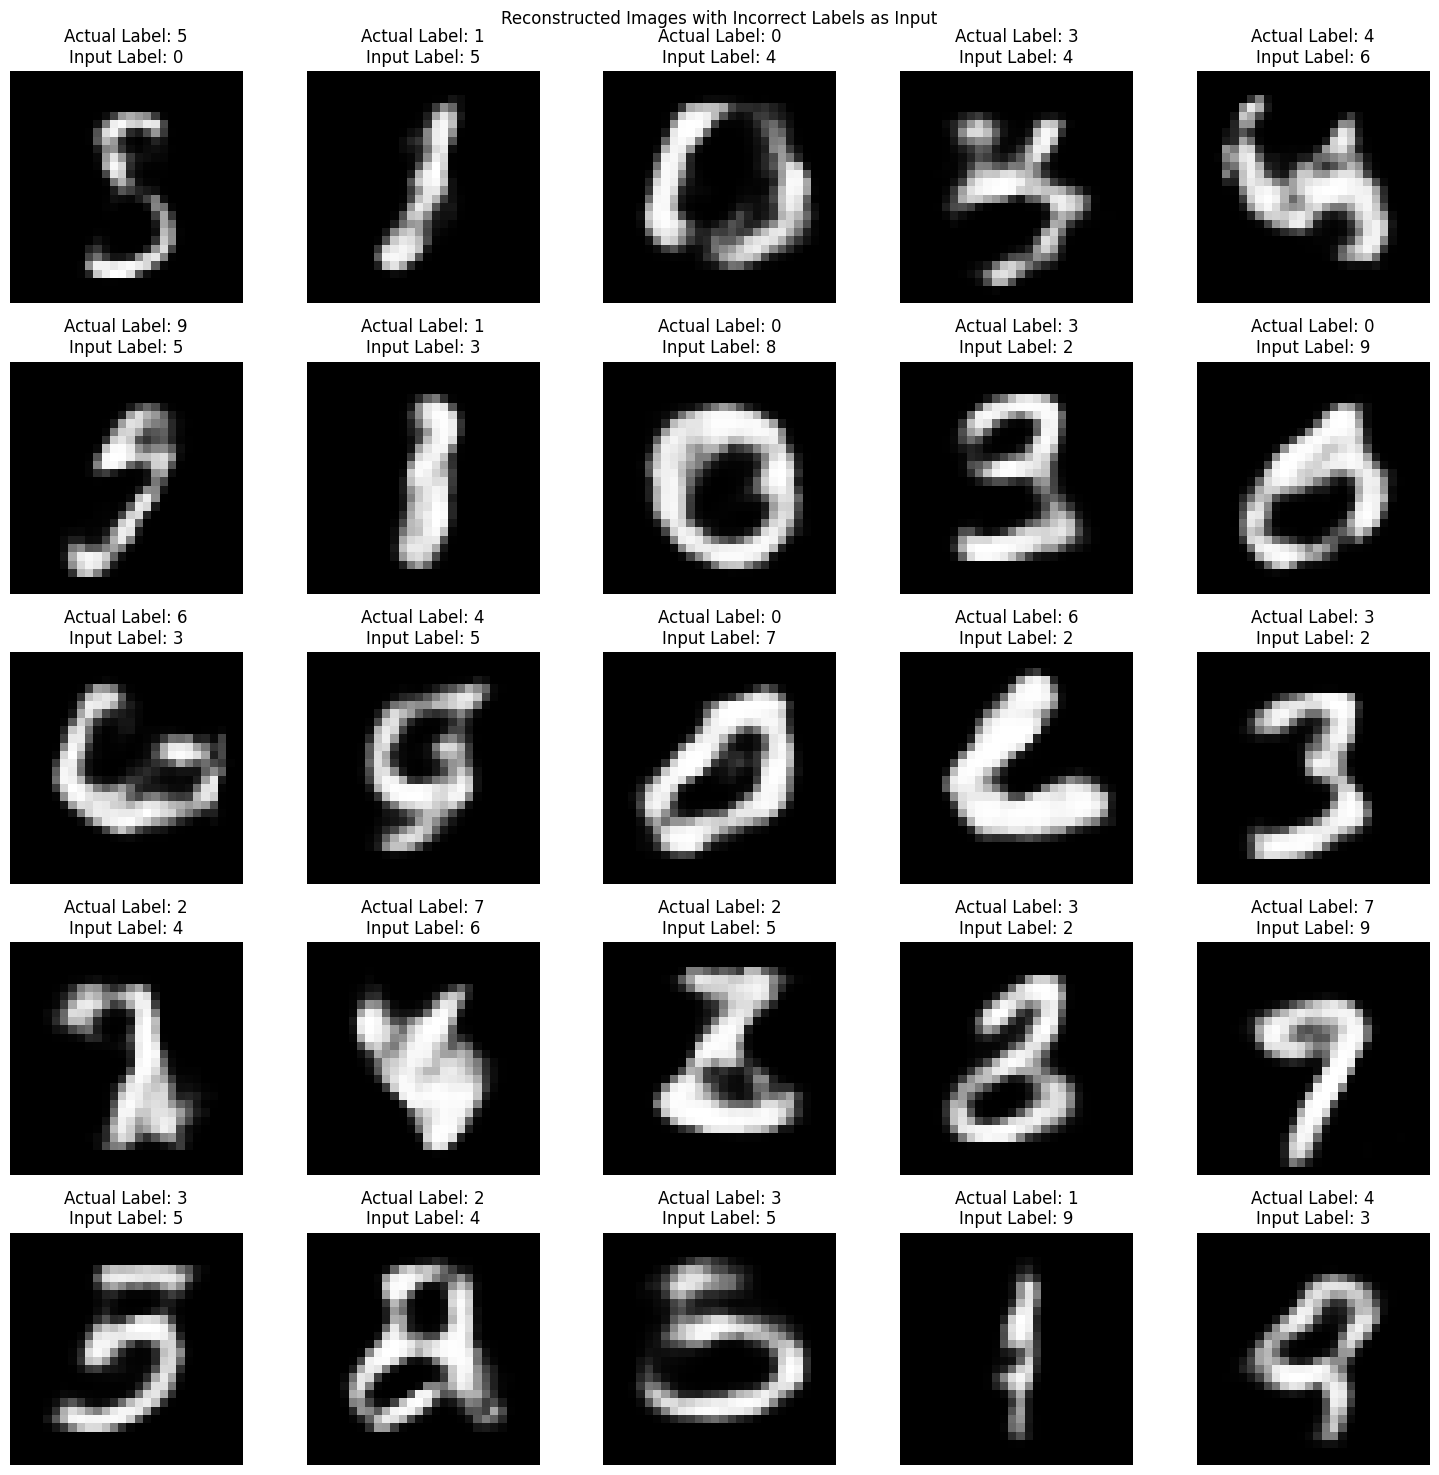

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
import random

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=25, shuffle=True)

# Function to randomly change labels
def random_swap_labels(labels):
    wrong_labels = labels.clone()
    for i in range(len(wrong_labels)):
        while True:
            wrong_label = random.randint(0, 9)
            if wrong_label != labels[i]:
                wrong_labels[i] = wrong_label
                break
    return wrong_labels

# Load VAE model (assuming it's already trained and loaded)
vae = VAE()
vae.load_state_dict(torch.load('vae_mnist.pth'))  # Assuming the model is saved as 'vae_mnist.pth'
vae.eval()

# Get a batch of images and their correct labels
images, correct_labels = next(iter(data_loader))
wrong_labels = random_swap_labels(correct_labels)

# Pass through VAE with wrong labels
with torch.no_grad():
    reconstructed_images, _, _ = vae(images, wrong_labels)

# Prepare for visualization
images = images.numpy()
reconstructed_images = reconstructed_images.numpy().reshape(-1, 1, 28, 28)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Reconstructed Images with Incorrect Labels as Input")

for i in range(25):
    ax = axs[i // 5, i % 5]
    ax.imshow(reconstructed_images[i, 0], cmap='gray')
    ax.set_title(f"Actual Label: {correct_labels[i]}\nInput Label: {wrong_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()
